# Using EcoFOCIpy to process raw field data

**Cruise DY2103 (FOCI Spring Mooring Cruise)

**Processed by Shaun Bell**

## CTD / Profile Data

Basic workflow for each instrument grouping is *(initial archive level)*:
- SBE workflow must happen first **done (performed on seperate windows system to convert to cnv)**
- output initial files (pandas->csv) **ERDDAP NRT** when no meta data is added.  Good for quick analysis

Other than hosting on an erddap server, the above can be done at sea

For furthur processing, QC and archiving, the following tasks are to be done *(working or final data level)*:
- Add metadata from cruise yaml files created from cast logs
- apply any calibrations or corrections
    + field corrections
    + offsets
    + spike analysis
    + some QC were available... this would be old-school simple bounds mostly
- save as CF netcdf via xarray or potentially csv file: so many of the steps above are optional
    + **ERDDAP NRT** if no corrections, offsets or time bounds are applied but some meta data is (can be csv as this is useful at sea)
    + **Working and awaiting QC** has no ERDDAP representation and is a holding spot
    + **ERDDAP Final** fully calibrated, qc'd and populated with meta information

Plot for preview and QC
- TSSigma, TOXYChlor, TurbParTrans


In [1]:
import yaml
import glob

import EcoFOCIpy.io.sbe_ctd_parser as sbe_ctd_parser #<- instrument specific
import EcoFOCIpy.io.ncCFsave as ncCFsave
import EcoFOCIpy.metaconfig.load_config as load_config
import EcoFOCIpy.math.geotools as geotools

## At Sea NRT Processing

This stage will essentially simplify the cnv files into a format that can be used by most including a preliminary erddap client.  It does not add metadata and is not in anyway qc'd beyond the seabird processing.  If up and down files are maintained, it will analyse these too (mostly for later plotting and evaluation of thermal interface properties)

In [2]:
sample_data_dir = '/Users/bell/ecoraid/2021/CTDcasts/dy2103/' #root path to cruise directory
ecofocipy_dir = '/Users/bell/Programs/EcoFOCIpy/'

In [3]:
###############################################################
# edit to point to {cruise sepcific} raw datafiles 
datafile = sample_data_dir+'rawconverted/' #<- point to cruise and process all files within
cruise_name = 'DY2103' #no hyphens
inst_meta_file = sample_data_dir+'logs/FOCI_standard_CTD.yaml'
###############################################################

#init and load data
cruise = sbe_ctd_parser.sbe9_11p()
filename_list = sorted(glob.glob(datafile + '*.cnv'))

(cruise_data,cruise_header) = cruise.parse(filename_list)

In [4]:
#this line adds available NMEA data to csv files for NRT/Preliminary erddap hosting... if there isn't an NMEA string, you will have to pull the locations
#  from the cast logs and output either a .nc or a more elaborate csv file furthur in to this process
NMEA_location = True
verbose = False

if NMEA_location:
    
    for cast in cruise_header.keys():
        cruise_data[cast][['time','latitude','longitude','profileid']] = ('0',0,0,'0')
        cruise_data[cast][['time','latitude','longitude','profileid']] = (cruise_header[cast]['NMEAtime'],
              geotools.latlon_convert(cruise_header[cast]['NMEALat'],cruise_header[cast]['NMEALon'])[0],
              geotools.latlon_convert(cruise_header[cast]['NMEALat'],cruise_header[cast]['NMEALon'])[1],
              cast.split('.')[0])
        if verbose:
            print(cruise_header[cast]['NMEAtime'],
                  geotools.latlon_convert(cruise_header[cast]['NMEALat'],cruise_header[cast]['NMEALon'])[0],
                  geotools.latlon_convert(cruise_header[cast]['NMEALat'],cruise_header[cast]['NMEALon'])[1])

In [5]:
#save downcast csv to file for viewing - really this is just a cleaned up cnv file
for cast in cruise_data.keys():
#     print(f'Processing Cast {cast}')
    cruise_data[cast].to_csv(sample_data_dir+cast.replace('cnv','csv'))

## Post Cruise Processing with additional meta information

In [6]:
###############################################################
# edit to point to {cruise sepcific} raw datafiles 
datafile = sample_data_dir+'rawconverted/' #<- point to cruise and process all files within
cruise_name = 'DY2103' #no hyphens
cruise_meta_file = sample_data_dir+'logs/DY2103.yaml'
inst_meta_file = sample_data_dir+'logs/FOCI_standard_CTDplusrinko.yaml'
group_meta_file = ecofocipy_dir+'staticdata/institutional_meta_example.yaml'
inst_shortname = '' #keep as placeholder for now
###############################################################

#init and load data
cruise = sbe_ctd_parser.sbe9_11p()
filename_list = sorted(glob.glob(datafile + '*.cnv'))

(cruise_data,cruise_header) = cruise.parse(filename_list)

## Time Properties

Not traditionally dealt with for CTD files as they are likely dynamically updated via GPS feed.  However, FOCI tends to label the date/time with the ***at depth*** time-stamp

## Depth Properties and other assumptions

- currently, all processing and binning (1m for FOCI) is done via seabird routines and the windows software.  This may change with the python ctd package for a few tasks

## Load all external meta information

In [7]:
#cruise info
with open(cruise_meta_file) as file:
    cruise_config = yaml.full_load(file)

#instrument info
with open(inst_meta_file) as file:
    inst_config = yaml.full_load(file)

#institutional info
with open(group_meta_file) as file:
    group_config = yaml.full_load(file)

In [8]:
cruise_config['CTDCasts']['CTD001']

{'id': 24484,
 'Vessel': 'R/V Oscar Dyson',
 'CruiseID': 'DY2103',
 'Project_Leg': '',
 'UniqueCruiseID': 'DY2103',
 'Project': 'Spring Mooring Cruise',
 'StationNo_altname': 'S1H4',
 'ConsecutiveCastNo': 'CTD001',
 'LatitudeDeg': 54,
 'LatitudeMin': 31.24,
 'LongitudeDeg': 165,
 'LongitudeMin': 10.42,
 'GMTDay': 3,
 'GMTMonth': 'MAY',
 'GMTYear': 2021,
 'GMTTime': 61980,
 'DryBulb': 2.2,
 'RelativeHumidity': 60,
 'WetBulb': -99.9,
 'Pressure': 1011,
 'SeaState': '-99',
 'Visibility': '-99',
 'WindDir': 262,
 'WindSpd': 19.0,
 'CloudAmt': '-99',
 'CloudType': '-99',
 'Weather': '-99',
 'SurfaceTemp': -99.9,
 'BottomDepth': 90,
 'StationNameID': '',
 'MaxDepth': 81,
 'InstrumentSerialNos': 'Press SN = 0291, Pri Temp SN = SBE3-4379 , Sec Temp SN = SBE3-2376, Pri Cond SN = SBE4-2985 , Sec Cond Sn = SBE4-3127, PAR Sn = 70497, Fluor Sn = FLNTU-2057, pri O2 Sn = SBE43-1961 , sec O2 Sn =  SBE43-1876 , ch6/7 = rinko optode',
 'Notes': 'Snow squalls in vicinity, large swells. Test and training 

In [9]:
cruise_data['ctd073.cnv'].columns

Index(['c0mS/cm', 'c1mS/cm', 'flECO-AFL', 'sbeox0V', 't090C', 't190C', 'timeS',
       'sbeox1V', 'par', 'turbWETntu0', 'upoly0', 'v6', 'sal00', 'sal11',
       'sigma-t00', 'sigma-t11', 'sbeox0ML/L', 'sbox0Mm/Kg', 'sbeox0PS',
       'sbeox1ML/L', 'sbox1Mm/Kg', 'sbeox1PS', 'nbin', 'flag'],
      dtype='object')

In [10]:
for cast in cruise_data.keys():
    print(f'Processing Cast {cast}')
    try:
        #output cruise cast stats here
        #cruise_data[cast].describe()
        #cruise_data['ctd001.cnv'].hist() - seaborn may have a better summary plot than just a bunch of histograms
        #sns.pairplot(cruise_data[cast])

        cruise_data[cast] = cruise_data[cast].rename(columns={
                            't090C':'temperature_ch1',
                            't190C':'temperature_ch2',
                            'sal00':'salinity_ch1',
                            'sal11':'salinity_ch2',
                            'sbox0Mm/Kg':'oxy_conc_ch1',
                            'sbeox0ML/L':'oxy_concM_ch1',
                            'sbox1Mm/Kg':'oxy_conc_ch2',
                            'sbeox1ML/L':'oxy_concM_ch2',
                            'sbeox0PS':'oxy_percentsat_ch1',
                            'sbeox1PS':'oxy_percentsat_ch2',
                            'sigma-t00':'sigma_t_ch1',
                            'sigma-t11':'sigma_t_ch2',
                            'CStarAt0':'Attenuation',
                            'CStarTr0':'Transmittance',
                            'flECO-AFL':'chlor_fluorescence',
                            'turbWETntu0':'turbidity',
                            'upoly0':'temperature_rinko',
                            'v6':'voltage_rinko',
                            'empty':'empty', #this will be ignored
                            'flag':'flag'})

        cruise_data[cast].index.rename('depth',inplace=True)
        #cruise_data[cast].sample()

        cruise_data_nc = ncCFsave.EcoFOCI_CFnc(df=cruise_data[cast], 
                                    instrument_yaml=inst_config, 
                                    operation_yaml=cruise_config,
                                    operation_type='ctd')
        cruise_data_nc.expand_dimensions(dim_names=['latitude','longitude','time'],geophys_sort=False)
        cruise_data_nc.variable_meta_data(variable_keys=list(cruise_data[cast].columns.values),drop_missing=True)
        cruise_data_nc.dimension_meta_data(variable_keys=['depth','latitude','longitude','time'])
        try:
            cruise_data_nc.temporal_geospatioal_meta_data_ctd(positiveE=False,conscastno=cast.split('.')[0])
        except:
            pass #fail on up and downcasts
        cruise_data_nc.var_qcflag_init(dim_names=['depth','latitude','longitude','time'])

        #interp to sfc for list of vars
        cruise_data_nc.interp2sfc(novars=['par'])
        
        #add global attributes
        cruise_data_nc.deployment_meta_add(conscastno=cast.upper().split('.')[0])
        cruise_data_nc.get_xdf()

        #add instituitonal global attributes
        cruise_data_nc.institution_meta_add(group_config)

        #add creation date/time - provenance data
        cruise_data_nc.provinance_meta_add()

        #provide intial qc status field
        cruise_data_nc.qc_status(qc_status='unknown')

        cast = cast.split('.')[0].split('d')[-1]
        cruise_data_nc.xarray2netcdf_save(xdf = cruise_data_nc.get_xdf(),
                               filename=sample_data_dir+cruise_name+'c'+cast.zfill(3)+'_ctd.nc',format="NETCDF3_CLASSIC")
        
        if not cast[0] in ['d','u']: #dont save editable up and downcast files, just nc files for plotting... all u/d files can be removed after final data
            cruise_data_nc.get_xdf().to_dataframe().to_csv(sample_data_dir+cruise_name+'c'+cast.zfill(3)+'_ctd.to_edit.csv')
    except:
        print('Conversion Failed')

Processing Cast ctd001.cnv
Processing Cast ctd002.cnv
Processing Cast ctd003.cnv
Processing Cast ctd004.cnv
Processing Cast ctd005.cnv
Processing Cast ctd006.cnv
Processing Cast ctd007.cnv
Processing Cast ctd008.cnv
Processing Cast ctd009.cnv
Processing Cast ctd010.cnv
Processing Cast ctd011.cnv
Processing Cast ctd012.cnv
Processing Cast ctd013.cnv
Processing Cast ctd014.cnv
Processing Cast ctd015.cnv
Processing Cast ctd016.cnv
Processing Cast ctd017.cnv
Processing Cast ctd017test.cnv
Conversion Failed
Processing Cast ctd018.cnv
Processing Cast ctd019.cnv
Processing Cast ctd020.cnv
Processing Cast ctd021.cnv
Conversion Failed
Processing Cast ctd022.cnv
Processing Cast ctd023.cnv
Processing Cast ctd024.cnv
Processing Cast ctd025.cnv
Processing Cast ctd026.cnv
Processing Cast ctd027.cnv
Processing Cast ctd028.cnv
Processing Cast ctd029.cnv
Processing Cast ctd030.cnv
Processing Cast ctd031.cnv
Processing Cast ctd032.cnv
Processing Cast ctd033.cnv
Processing Cast ctd034.cnv
Processing Cast

## QC Next Steps

QC of data (plot parameters with other instruments)
- be sure to updated the qc_status for the file and the history for future steps
- from NRT csv files... make edits then use that to modify netcdf?
- **Better Yet** export netcdf files with variable flags to csv and edit then reingest and modify
    - modify netcdf in place and provide a qcflag?

### Make General Plots
- 1:1 plots for paired instruments for each cast (tells if a sensor failed)
- TS_Sigmat, Chlor/Par/Turb, Oxy,Temp
- T/S property property plot
- upcast/downcast plt

### Determine if AutoSal run needs to be done
- easy route, use bottle data to determine delta between channels (this is upcast data though and small sample)
- more data, use downcast to dtermine delta between channels as a function of time

### Likely first edits
- research issues noted in cruise logs
- remove failed instrument (clogs, or other challenges that arent correctable)
- extrapolate to sfc (not par though)
- despike depths (interpolate between depths or make missing)

### Likely secondary edits
- oxygen offsets and sat recalc
- chlor offset from deep casts if available
- sigma-t recalculation from changed T/S
- check for common issues
    - lags in salinity when going through interface
    
### Final Steps
+ Primary vars need flags (T/S/Oxy), derived can stay 0 (sigmat, oxy sat, etc)
- specifying QC flags 0->1 or 0->2 (to good or probably good)
- specifying QC flags 0->4 when removed (bad)
- specifying QC flags 0->9 if missing and not added or 0->8 if interpolated

## Plotting

In [11]:
import EcoFOCIpy.plots.sbe_ctd_plots as sbe_ctd_plots
import os
import xarray as xa
import seaborn as sns
import numpy as np

In [17]:
sample_data_dir = sample_data_dir + 'working/'

In [18]:
for cast in sorted(os.listdir(sample_data_dir)):
    if cast.endswith('.nc'):
        cruise_data_nc = xa.load_dataset(sample_data_dir+cast)
        ctd_df = cruise_data_nc.to_dataframe()
        
        sbe_p = sbe_ctd_plots.CTDProfilePlot()
        plt,fig =sbe_p.plot3var(varname=['temperature_ch1','temperature_ch2',
                                         'salinity_ch1','salinity_ch2',
                                         'sigma_t_ch1','sigma_t_ch2'],
                          xdata=[ctd_df.temperature_ch1,ctd_df.temperature_ch2,
                                 ctd_df.salinity_ch1,ctd_df.salinity_ch2,
                                 ctd_df.sigma_t_ch1,ctd_df.sigma_t_ch2],
                          ydata=ctd_df.index.get_level_values('depth'),
                          secondary=True,
                          xlabel=['Temperature','Salinity','SigmaT'])

        DefaultSize = fig.get_size_inches()
        fig.set_size_inches( (DefaultSize[0], DefaultSize[1]*3) )
        plt.savefig(sample_data_dir+cast.zfill(3)+'_TempSalSigmaT.png')
        plt.close(fig)

In [19]:
for cast in sorted(os.listdir(sample_data_dir)):
    if cast.endswith('.nc'):
        cruise_data_nc = xa.load_dataset(sample_data_dir+cast)
        ctd_df = cruise_data_nc.to_dataframe()
        
        sbe_p = sbe_ctd_plots.CTDProfilePlot()
        plt,fig =sbe_p.plot2var(varname=['temperature_ch1','temperature_ch2','oxy_percentsat_ch1','oxy_percentsat_ch2'],
                          xdata=[ctd_df.temperature_ch1,ctd_df.temperature_ch2,ctd_df.oxy_percentsat_ch1,ctd_df.oxy_percentsat_ch1],
                          ydata=ctd_df.index.get_level_values('depth'),
                          secondary=True,
                          xlabel=['Temperature','Oxygen Saturation'])

        DefaultSize = fig.get_size_inches()
        fig.set_size_inches( (DefaultSize[0], DefaultSize[1]*3) )
        plt.savefig(sample_data_dir+cast.zfill(3)+'_TempOxy.png')
        plt.close(fig)

In [20]:
for cast in sorted(os.listdir(sample_data_dir)):
    if cast.endswith('.nc'):
        cruise_data_nc = xa.load_dataset(sample_data_dir+cast)
        ctd_df = cruise_data_nc.to_dataframe()
        
        sbe_p = sbe_ctd_plots.CTDProfilePlot()
        plt,fig =sbe_p.plot3var(varname=['par','','turbidity','','chlor_fluorescence',''],
                          xdata=[ctd_df.par,np.array([]),ctd_df.turbidity,np.array([]),ctd_df.chlor_fluorescence,np.array([])],
                          ydata=ctd_df.index.get_level_values('depth'),
                          secondary=True,
                          xlabel=['PAR','Fluor','Turbidity'])

        DefaultSize = fig.get_size_inches()
        fig.set_size_inches( (DefaultSize[0], DefaultSize[1]*3) )
        plt.savefig(sample_data_dir+cast.zfill(3)+'_PARTurbFluor.png')
        plt.close(fig)

## Salinity difference as a function of Cast

In [42]:
for cast in sorted(os.listdir(sample_data_dir)):
    if cast.endswith('.nc'):
        cruise_data_nc = xa.load_dataset(sample_data_dir+cast)
        print(cast, 'mean:', (cruise_data_nc.salinity_ch1 - cruise_data_nc.salinity_ch2).mean().values,
             'median:', (cruise_data_nc.salinity_ch1 - cruise_data_nc.salinity_ch2).median().values)

DY2103c001_ctd.nc mean: -0.0009666666666661479 median: -0.0010000000000012221
DY2103c002_ctd.nc mean: -0.0010303030303032128 median: -0.0009999999999976694
DY2103c003_ctd.nc mean: -0.0010606060606064955 median: -0.001100000000000989
DY2103c004_ctd.nc mean: -0.0011750000000000248 median: -0.001100000000000989
DY2103c005_ctd.nc mean: -0.001394444444444846 median: -0.001300000000000523
DY2103c006_ctd.nc mean: -0.0015750000000010838 median: -0.0016000000000033765
DY2103c007_ctd.nc mean: -2.6086956522605128e-05 median: -0.001100000000000989
DY2103c008_ctd.nc mean: -0.0026534246575334645 median: -0.001300000000000523
DY2103c009_ctd.nc mean: -0.0013014705882353433 median: -0.001300000000000523
DY2103c010_ctd.nc mean: -0.03045633802816859 median: -0.029699999999998283
DY2103c011_ctd.nc mean: -0.0012782608695649158 median: -0.001300000000000523
DY2103c012_ctd.nc mean: -0.0013441176470587212 median: -0.0013999999999967372
DY2103c013_ctd.nc mean: -0.00850447761194084 median: -0.008600000000001273

## xarray -> pandas -> csv 
- for editing, use the `to_edit.csv` files

## csv --> pandas --> xarry (update original including qc status and history)
- on reingest, change 0->1 flags for T/S/Oxy/Chlor/Par (via visual inspection), others are 0 or as reported
- add history to reflect scientific QC applied

### final pairplot or something could give good analysis to results

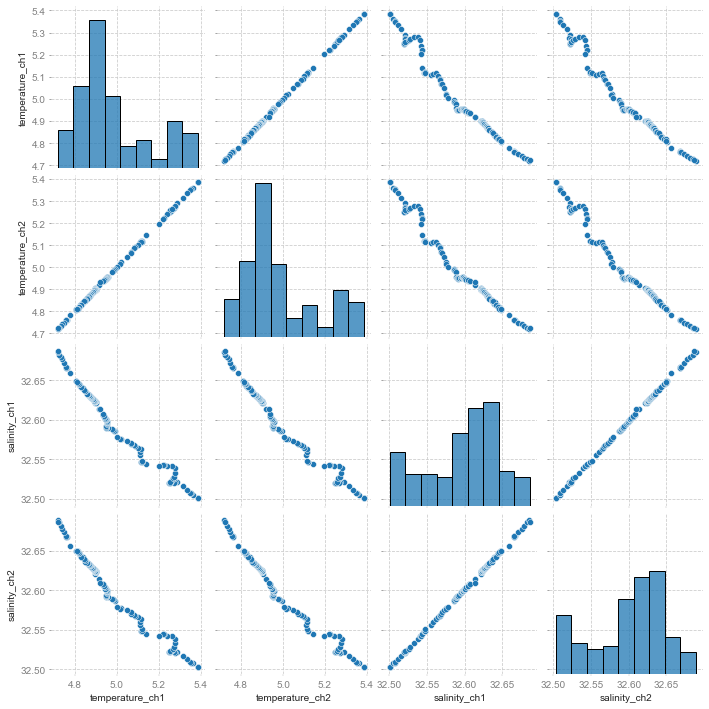

In [23]:
#cruise_data_nc.get_xdf().to_dataframe().columns
sns.pairplot(cruise_data_nc.to_dataframe()[['temperature_ch1', 'temperature_ch2','salinity_ch1','salinity_ch2']])